In [1]:
import sys
import joblib
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score
import torch.nn.functional as F
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.api.types import CategoricalDtype
import time

In [2]:
# Store file path to folders with gait sequence and characteristics predictions from lower back signal
gait_dir = "/results_mobilise_ionescu"
# Store file path to folders with signal from wrist sensor
wrist_dir = "XXXX"
# Output directory
output_dir = 'Outputs/Lower Back Predictions Mapped To Wrist/'

# Extract list of subjects with lower back predictions
subjects = os.listdir(gait_dir)
folder_name=subjects[0] #Use one subject

In [3]:
# Load wrist signal data
wrist_folder_path = os.path.join(wrist_dir, folder_name)
csv_path = os.path.join(wrist_folder_path, 'combined_ax6_df.csv')
df = pd.read_csv(csv_path, usecols=['accel_x', 'accel_y', 'accel_z'])

df.reset_index(inplace=True)  # Add row numbers as an "index" column

# Load gait sequence data
gs_folder_path = os.path.join(gait_dir, folder_name, 'gs_list.csv')
gs = pd.read_csv(gs_folder_path)

# Expand gait sequence to a DataFrame of indices for walking intervals
walking_df = pd.DataFrame({'index': np.concatenate([np.arange(row['start'], row['end'] + 1) for _, row in gs.iterrows()])})
walking_df['lower_back_mapped_value'] = 1

# Check for duplicates in walking_df
if walking_df.duplicated(subset=['index']).any():
    print(f"Duplicate indices found in walking_df for subject: {folder_name}")
    walking_df.drop_duplicates(subset=['index'], keep='first', inplace=True)


In [4]:
# Load gait analysis data
analysis_folder_path = os.path.join(gait_dir, folder_name, 'gait_analysis_results.csv')
gait_analysis = pd.read_csv(analysis_folder_path, usecols=['sec_center_samples', 'cadence_spm',
                                                           'stride_length_m', 'walking_speed_mps'])

# Expand gait analysis intervals and add features
gait_analysis['start'] = (gait_analysis['sec_center_samples'] - 50).astype(int)
gait_analysis['end'] = (gait_analysis['sec_center_samples'] + 49).astype(int)

analysis_intervals = []
for row in gait_analysis.itertuples(index=False):
    for idx in range(row.start, row.end + 1):
        analysis_intervals.append({
            'index': idx,
            'cadence_spm': row.cadence_spm,
            'stride_length_m': row.stride_length_m,
            'walking_speed_mps': row.walking_speed_mps
        })
analysis_intervals = pd.DataFrame(analysis_intervals)

# Check for duplicates in analysis_intervals
if analysis_intervals.duplicated(subset=['index']).any():
    print(f"Duplicate indices found in analysis_intervals for subject: {folder_name}")
    analysis_intervals.drop_duplicates(subset=['index'], keep='first', inplace=True)
walking_df = walking_df.merge(analysis_intervals, on='index', how='left')

In [5]:
# Step 2: Inner join walking data to wrist signal data
df = df.merge(walking_df, on='index', how='inner')
df=df[pd.isna(df.walking_speed_mps)==False]

In [14]:
X_test=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']][0:50000]
X=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']][50000:]
y_test=df['walking_speed_mps'][0:50000]
y=df['walking_speed_mps'][50000:]
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      walking_speed_mps   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 5.026e+07
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:21:37   Log-Likelihood:             1.6972e+07
No. Observations:             9480117   AIC:                        -3.394e+07
Df Residuals:                 9480111   BIC:                        -3.394e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5871   8.01e-05  -73

In [15]:
X_test = sm.add_constant(X_test)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Predictions vs Truth:")
comp = pd.DataFrame({"Truth": y_test, "Prediction": predictions})
print(comp)

print("\nScoring Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Predictions vs Truth:
          Truth  Prediction
30     0.625807    0.639040
31     0.625807    0.639040
32     0.625807    0.639028
33     0.625807    0.639036
34     0.625807    0.639035
...         ...         ...
51697  0.490273    0.552257
51698  0.490273    0.552265
51699  0.490273    0.552283
51700  0.490273    0.552234
51701  0.490273    0.552217

[50000 rows x 2 columns]

Scoring Metrics:
Mean Absolute Error (MAE): 0.0283
Mean Squared Error (MSE): 0.0023
Root Mean Squared Error (RMSE): 0.0483
R² Score: 0.9423


# Another Patient 

In [16]:
folder_name=subjects[1] #Use one subject
# Load wrist signal data
wrist_folder_path = os.path.join(wrist_dir, folder_name)
csv_path = os.path.join(wrist_folder_path, 'combined_ax6_df.csv')
df = pd.read_csv(csv_path, usecols=['accel_x', 'accel_y', 'accel_z'])

df.reset_index(inplace=True)  # Add row numbers as an "index" column


In [17]:

# Load gait sequence data
gs_folder_path = os.path.join(gait_dir, folder_name, 'gs_list.csv')
gs = pd.read_csv(gs_folder_path)

# Expand gait sequence to a DataFrame of indices for walking intervals
walking_df = pd.DataFrame({'index': np.concatenate([np.arange(row['start'], row['end'] + 1) for _, row in gs.iterrows()])})
walking_df['lower_back_mapped_value'] = 1

# Check for duplicates in walking_df
if walking_df.duplicated(subset=['index']).any():
    print(f"Duplicate indices found in walking_df for subject: {folder_name}")
    walking_df.drop_duplicates(subset=['index'], keep='first', inplace=True)


In [18]:
# Load gait analysis data
analysis_folder_path = os.path.join(gait_dir, folder_name, 'gait_analysis_results.csv')
gait_analysis = pd.read_csv(analysis_folder_path, usecols=['sec_center_samples', 'cadence_spm',
                                                           'stride_length_m', 'walking_speed_mps'])

# Expand gait analysis intervals and add features
gait_analysis['start'] = (gait_analysis['sec_center_samples'] - 50).astype(int)
gait_analysis['end'] = (gait_analysis['sec_center_samples'] + 49).astype(int)

analysis_intervals = []
for row in gait_analysis.itertuples(index=False):
    for idx in range(row.start, row.end + 1):
        analysis_intervals.append({
            'index': idx,
            'cadence_spm': row.cadence_spm,
            'stride_length_m': row.stride_length_m,
            'walking_speed_mps': row.walking_speed_mps
        })
analysis_intervals = pd.DataFrame(analysis_intervals)

# Check for duplicates in analysis_intervals
if analysis_intervals.duplicated(subset=['index']).any():
    print(f"Duplicate indices found in analysis_intervals for subject: {folder_name}")
    analysis_intervals.drop_duplicates(subset=['index'], keep='first', inplace=True)
walking_df = walking_df.merge(analysis_intervals, on='index', how='left')

In [19]:
# Step 2: Inner join walking data to wrist signal data
df = df.merge(walking_df, on='index', how='inner')
df=df[pd.isna(df.walking_speed_mps)==False]

## All subjects

In [ ]:
# Store file path to folders with gait sequence and characteristics predictions from lower back signal
gait_dir = "/results_mobilise_ionescu/"
# Store file path to folders with signal from wrist sensor
wrist_dir = "XXXX"
# Output directory
output_dir = 'Outputs/Lower Back Predictions Mapped To Wrist/'

# Extract list of subjects with lower back predictions
subjects = os.listdir(gait_dir)

train_first=True
maes=[]
r_s=[]
adj_rs=[]
mses=[]
rmses=[]
import pickle
# Loop through all subjects
for folder_name in subjects:
    print(f"Processing subject: {folder_name}")

    # Start timer
    start_time = time.time()

    # Load wrist signal data
    wrist_folder_path = os.path.join(wrist_dir, folder_name)
    csv_path = os.path.join(wrist_folder_path, 'combined_ax6_df.csv')
    df = pd.read_csv(csv_path, usecols=['accel_x', 'accel_y', 'accel_z'])
    
    signal_load_time = time.time() - start_time
    print(f"Wrist file load time: {signal_load_time:.2f} seconds")
    
    df.reset_index(inplace=True)  # Add row numbers as an "index" column

    # Start timer for walking_df creation
    walking_df_start_time = time.time()

    # Load gait sequence data
    gs_folder_path = os.path.join(gait_dir, folder_name, 'gs_list.csv')
    gs = pd.read_csv(gs_folder_path)

    # Expand gait sequence to a DataFrame of indices for walking intervals
    walking_df = pd.DataFrame({'index': np.concatenate([np.arange(row['start'], row['end'] + 1) for _, row in gs.iterrows()])})
    walking_df['lower_back_mapped_value'] = 1
    
    
    # Check for duplicates in walking_df
    if walking_df.duplicated(subset=['index']).any():
        print(f"Duplicate indices found in walking_df for subject: {folder_name}")
        walking_df.drop_duplicates(subset=['index'], keep='first', inplace=True)

    # Load gait analysis data
    analysis_folder_path = os.path.join(gait_dir, folder_name, 'gait_analysis_results.csv')
    gait_analysis = pd.read_csv(analysis_folder_path, usecols=['sec_center_samples', 'cadence_spm',
                                                               'stride_length_m', 'walking_speed_mps'])

    # Expand gait analysis intervals and add features
    gait_analysis['start'] = (gait_analysis['sec_center_samples'] - 50).astype(int)
    gait_analysis['end'] = (gait_analysis['sec_center_samples'] + 49).astype(int)
    
    analysis_intervals = []
    for row in gait_analysis.itertuples(index=False):
        for idx in range(row.start, row.end + 1):
            analysis_intervals.append({
                'index': idx,
                'cadence_spm': row.cadence_spm,
                'stride_length_m': row.stride_length_m,
                'walking_speed_mps': row.walking_speed_mps
            })
    analysis_intervals = pd.DataFrame(analysis_intervals)
    
    # Check for duplicates in analysis_intervals
    if analysis_intervals.duplicated(subset=['index']).any():
        print(f"Duplicate indices found in analysis_intervals for subject: {folder_name}")
        analysis_intervals.drop_duplicates(subset=['index'], keep='first', inplace=True)

    # Merge the walking intervals and analysis features
    walking_df = walking_df.merge(analysis_intervals, on='index', how='left')

    walking_df_time = time.time() - walking_df_start_time
    print(f"Time to create walking_df: {walking_df_time:.2f} seconds")

    # Step 2: Inner join walking data to wrist signal data
    df = df.merge(walking_df, on='index', how='inner')
    df=df[pd.isna(df.walking_speed_mps)==False]
    if train_first ==True:
        X_test=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']][0:50000]
        X=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']][50000:]
        y_test=df['walking_speed_mps'][0:50000]
        y=df['walking_speed_mps'][50000:]
        X = sm.add_constant(X)  
        model = sm.OLS(y, X).fit()
        print(model.summary())
        train_first=False
    else:
        X_test=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']]
        y_test=df['walking_speed_mps']
    X_test = sm.add_constant(X_test)
    predictions = model.predict(X_test)
    try:
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
         # Number of samples (n) and predictors (p)
        n = len(X_test)  # Number of data points
        p = 5  # Number of independent variables (excluding the intercept)
        # Compute Adjusted R^2
        adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
        
        print("Predictions vs Truth:")
        comp = pd.DataFrame({"Truth": y_test, "Prediction": predictions})
        print(comp)
        
        print("\nScoring Metrics:")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"Adjusted R² Score: {adjusted_r2:.4f}")
        maes=maes+[float(mae)]
        r_s=r_s+ [float(r2)]
        adj_rs=adj_rs+[float(adjusted_r2)]
        mses=mses+ [float(mse)]
        rmses=rmses+[float(rmse)]
        results=[maes,r_s,adj_rs,mses,rmses]
        with open("/mnt/Kate/SSL_wrist/saved_data.pkl", "wb") as file:  # "wb" = write binary mode
            pickle.dump(results, file)
        print("Data has been saved successfully!")
    except:
        maes=maes+[folder_name]
        r_s=r_s+ [folder_name]
        adj_rs=adj_rs+[folder_name]
        mses=mses+ [folder_name]
        rmses=rmses+[folder_name]
        results=[maes,r_s,adj_rs,mses,rmses]
        with open("/mnt/Kate/SSL_wrist/saved_data.pkl", "wb") as file:  # "wb" = write binary mode
            pickle.dump(results, file)
        print("Data has been saved successfully, skipped file: ",folder_name)


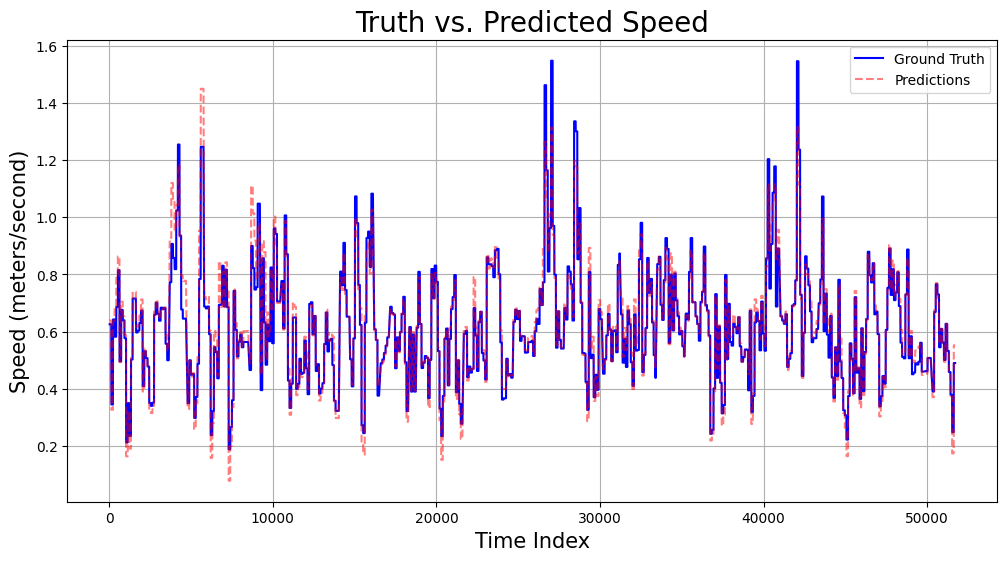

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Ground Truth",color="blue")
plt.plot(predictions, label="Predictions",linestyle='--',color="red",alpha=0.5)
plt.xlabel("Time Index", fontsize=15)
plt.ylabel("Speed (meters/second)", fontsize=15)
plt.title("Truth vs. Predicted Speed", fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Loop through all subjects
for folder_name in subjects[6:]:
    print(f"Processing subject: {folder_name}")

    # Start timer
    start_time = time.time()

    # Load wrist signal data
    wrist_folder_path = os.path.join(wrist_dir, folder_name)
    csv_path = os.path.join(wrist_folder_path, 'combined_ax6_df.csv')
    df = pd.read_csv(csv_path, usecols=['accel_x', 'accel_y', 'accel_z'])
    
    signal_load_time = time.time() - start_time
    print(f"Wrist file load time: {signal_load_time:.2f} seconds")
    
    df.reset_index(inplace=True)  # Add row numbers as an "index" column

    # Start timer for walking_df creation
    walking_df_start_time = time.time()

    # Load gait sequence data
    gs_folder_path = os.path.join(gait_dir, folder_name, 'gs_list.csv')
    gs = pd.read_csv(gs_folder_path)

    # Expand gait sequence to a DataFrame of indices for walking intervals
    walking_df = pd.DataFrame({'index': np.concatenate([np.arange(row['start'], row['end'] + 1) for _, row in gs.iterrows()])})
    walking_df['lower_back_mapped_value'] = 1
    
    
    # Check for duplicates in walking_df
    if walking_df.duplicated(subset=['index']).any():
        print(f"Duplicate indices found in walking_df for subject: {folder_name}")
        walking_df.drop_duplicates(subset=['index'], keep='first', inplace=True)

    # Load gait analysis data
    analysis_folder_path = os.path.join(gait_dir, folder_name, 'gait_analysis_results.csv')
    gait_analysis = pd.read_csv(analysis_folder_path, usecols=['sec_center_samples', 'cadence_spm',
                                                               'stride_length_m', 'walking_speed_mps'])

    # Expand gait analysis intervals and add features
    gait_analysis['start'] = (gait_analysis['sec_center_samples'] - 50).astype(int)
    gait_analysis['end'] = (gait_analysis['sec_center_samples'] + 49).astype(int)
    
    analysis_intervals = []
    for row in gait_analysis.itertuples(index=False):
        for idx in range(row.start, row.end + 1):
            analysis_intervals.append({
                'index': idx,
                'cadence_spm': row.cadence_spm,
                'stride_length_m': row.stride_length_m,
                'walking_speed_mps': row.walking_speed_mps
            })
    analysis_intervals = pd.DataFrame(analysis_intervals)
    
    # Check for duplicates in analysis_intervals
    if analysis_intervals.duplicated(subset=['index']).any():
        print(f"Duplicate indices found in analysis_intervals for subject: {folder_name}")
        analysis_intervals.drop_duplicates(subset=['index'], keep='first', inplace=True)

    # Merge the walking intervals and analysis features
    walking_df = walking_df.merge(analysis_intervals, on='index', how='left')

    walking_df_time = time.time() - walking_df_start_time
    print(f"Time to create walking_df: {walking_df_time:.2f} seconds")

    # Step 2: Inner join walking data to wrist signal data
    df = df.merge(walking_df, on='index', how='inner')
    df=df[pd.isna(df.walking_speed_mps)==False]
    if train_first ==True:
        X_test=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']][0:50000]
        X=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']][50000:]
        y_test=df['walking_speed_mps'][0:50000]
        y=df['walking_speed_mps'][50000:]
        X = sm.add_constant(X)  
        model = sm.OLS(y, X).fit()
        print(model.summary())
        train_first=False
    else:
        X_test=df[[ 'accel_x', 'accel_y', 'accel_z', 'cadence_spm', 'stride_length_m']]
        y_test=df['walking_speed_mps']
    X_test = sm.add_constant(X_test)
    predictions = model.predict(X_test)
    try:
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
         # Number of samples (n) and predictors (p)
        n = len(X_test)  # Number of data points
        p = 5  # Number of independent variables (excluding the intercept)
        # Compute Adjusted R^2
        adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
        
        print("Predictions vs Truth:")
        comp = pd.DataFrame({"Truth": y_test, "Prediction": predictions})
        print(comp)
        
        print("\nScoring Metrics:")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"Adjusted R² Score: {adjusted_r2:.4f}")
        maes=maes+[float(mae)]
        r_s=r_s+ [float(r2)]
        adj_rs=adj_rs+[float(adjusted_r2)]
        mses=mses+ [float(mse)]
        rmses=rmses+[float(rmse)]
        results=[maes,r_s,adj_rs,mses,rmses]
        with open("/mnt/Kate/SSL_wrist/saved_data.pkl", "wb") as file:  # "wb" = write binary mode
            pickle.dump(results, file)
        print("Data has been saved successfully!")
    except:
        maes=maes+[folder_name]
        r_s=r_s+ [folder_name]
        adj_rs=adj_rs+[folder_name]
        mses=mses+ [folder_name]
        rmses=rmses+[folder_name]
        results=[maes,r_s,adj_rs,mses,rmses]
        with open("/mnt/Kate/SSL_wrist/saved_data.pkl", "wb") as file:  # "wb" = write binary mode
            pickle.dump(results, file)
        print("Data has been saved successfully, skipped file: ",folder_name)


In [ ]:
len(subjects)

In [24]:
import pickle
with open("/saved_data.pkl", "rb") as file:  # "rb" = read binary mode
    loaded_data = pickle.load(file)

In [25]:
len(loaded_data[0])

23

In [26]:
loaded_data[0]

[0.021627063969912104,
 0.022951183330769898,
 0.025031567415502214,
 0.02389242350145983,
 0.021318696778856606,
 'NTP5DNA',
 0.014533739252680748,
 0.026283202742188375,
 'NNF2HPY',
 0.020093862869860483,
 0.0212331311952865,
 0.02240445459575346,
 0.018095299653500294,
 0.02383529943923226,
 0.0283977515350956,
 'N7TFS3G',
 0.023221701371108794,
 0.04149835211427385,
 0.019975500175868216,
 0.019971991041989344,
 0.020939672992184206,
 0.0133272404100313,
 0.019724607951395558]

In [27]:
def avg_metrics(lst):
    numeric_values = [x for x in lst if isinstance(x, (int, float))]
    return sum(numeric_values) / len(numeric_values) 
    
avg_scores=[]
for x in loaded_data:
    avg_scores=avg_scores+[avg_metrics(x)]

In [28]:
titles=["Average Mean Absolute Error (MAE):","Average R² Score:","Average Adjusted R² Score:","Average Mean Squared Error (MSE):","Average Root Mean Squared Error (RMSE):"]
for x in range(len(avg_scores)):
    print(titles[x],round(avg_scores[x],4))

Average Mean Absolute Error (MAE): 0.0224
Average R² Score: 0.9627
Average Adjusted R² Score: 0.9627
Average Mean Squared Error (MSE): 0.0013
Average Root Mean Squared Error (RMSE): 0.0349
